<a href="https://colab.research.google.com/github/yukinaga/minnano_ai/blob/master/section_5/train_middle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 中間層の学習
出力層のパラメータを更新する仕組みをニューラルネットワークに導入します。  
正解データを使ってネットワークを訓練し、正しく分類ができることを確認します。  

## ● 中間層のパラメータを更新
出力層の重みとバイアスを更新します。  
  
出力層で求めた$δ_o$を使って、中間層における修正量のベース$δ_m$を求めます。  
**$δ_m$ = $δ_o$ × 出力にかける重み × 活性化関数の微分形**  
  
活性化関数がシグモイド関数の場合、上記は以下の形になります。  
**$δ_m$ = $δ_o$ × 出力にかける重み × 出力 × (1 - 出力)**  
  
そして、この$\delta_m$を使って重みとバイアスの修正量を求めます。  
**重みの修正量 = - 学習係数 × $δ_m$ × 入力**  
**バイアスの修正量 = - 学習係数 × $δ_m$**  
  
以下のコードは、これらのこれらの式を使って中間層の各パラメータを1回だけ更新します。  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import random

iris = datasets.load_iris()
iris_data = iris.data
sl_data = iris_data[:100, 0].copy() # SetosaとVersicolor、Sepal length: copy()で元データが変更されない
sw_data = iris_data[:100, 1].copy() # SetosaとVersicolor、Sepal width

# 平均値を0に
sl_ave = np.average(sl_data)  # 平均値
sl_data -= sl_ave  # 平均値を引く
sw_ave = np.average(sw_data)
sw_data -= sw_ave

# 入力をリストに格納
train_data = []
for i in range(100):  # iには0から99までが入る
    correct = iris.target[i]
    train_data.append([sl_data[i], sw_data[i], correct])

# シグモイド関数
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# ニューロン
class Neuron:
    def __init__(self):  # 初期設定
        self.input_sum = 0.0
        self.output = 0.0

    def set_input(self, inp):
        self.input_sum += inp

    def get_output(self):
        self.output = sigmoid(self.input_sum)
        return self.output

    def reset(self):
        self.input_sum = 0
        self.output = 0

# ニューラルネットワーク
class NeuralNetwork:
    def __init__(self):  # 初期設定
        # 重み
        self.w_im = [[4.0, 4.0], [4.0, 4.0]]  # 入力:2 ニューロン数:2
        self.w_mo = [[1.0, -1.0]]  # 入力:2 ニューロン数:1

        # バイアス
        self.b_m = [2.0, -2.0]  # ニューロン数:2
        self.b_o = [-0.5]  # ニューロン数:1

        # 各層の宣言
        self.input_layer = [0.0, 0.0]
        self.middle_layer = [Neuron(), Neuron()]
        self.output_layer = [Neuron()]

    def commit(self, input_data):  # 実行
        # 各層のリセット
        self.input_layer[0] = input_data[0]  # 入力層は値を受け取るのみ
        self.input_layer[1] = input_data[1]
        self.middle_layer[0].reset()
        self.middle_layer[1].reset()
        self.output_layer[0].reset()

        # 入力層→中間層
        self.middle_layer[0].set_input(self.input_layer[0] * self.w_im[0][0])
        self.middle_layer[0].set_input(self.input_layer[1] * self.w_im[0][1])
        self.middle_layer[0].set_input(self.b_m[0])

        self.middle_layer[1].set_input(self.input_layer[0] * self.w_im[1][0])
        self.middle_layer[1].set_input(self.input_layer[1] * self.w_im[1][1])
        self.middle_layer[1].set_input(self.b_m[1])

        # 中間層→出力層
        self.output_layer[0].set_input(self.middle_layer[0].get_output() * self.w_mo[0][0])
        self.output_layer[0].set_input(self.middle_layer[1].get_output() * self.w_mo[0][1])
        self.output_layer[0].set_input(self.b_o[0])

        return self.output_layer[0].get_output()

    def train(self, correct):
        # 学習係数
        k = 0.3

        #  出力
        output_o = self.output_layer[0].output
        output_m0 = self.middle_layer[0].output
        output_m1 = self.middle_layer[1].output

        # δ
        delta_o = (output_o - correct) * output_o * (1.0 - output_o)
        delta_m0 = delta_o * self.w_mo[0][0] * output_m0 * (1.0 - output_m0)
        delta_m1 = delta_o * self.w_mo[0][1] * output_m1 * (1.0 - output_m1)
        

        # パラメータの更新
        self.w_mo[0][0] -= k * delta_o * output_m0
        self.w_mo[0][1] -= k * delta_o * output_m1
        self.b_o[0] -= k * delta_o

        self.w_im[0][0] -= k * delta_m0 * self.input_layer[0]
        self.w_im[0][1] -= k * delta_m0 * self.input_layer[1]
        self.w_im[1][0] -= k * delta_m1 * self.input_layer[0]
        self.w_im[1][1] -= k * delta_m1 * self.input_layer[1]
        self.b_m[0] -= k * delta_m0 
        self.b_m[1] -= k * delta_m1 


# ニューラルネットワークのインスタンス
neural_network = NeuralNetwork()

# 学習によるパラメータの変化
print("-------- Before train --------")
print(neural_network.w_im)
print(neural_network.w_mo)
print(neural_network.b_m)
print(neural_network.b_o)
neural_network.commit(train_data[0][:2])  # 順伝播
neural_network.train(train_data[0][2])  # 逆伝播
print("-------- After train --------")
print(neural_network.w_im)
print(neural_network.w_mo)
print(neural_network.b_m)
print(neural_network.b_o)

-------- Before train --------
[[4.0, 4.0], [4.0, 4.0]]
[[1.0, -1.0]]
[2.0, -2.0]
[-0.5]
-------- After train --------
[[4.001478355753436, 3.998402100654642], [3.99822531846368, 4.001918186781845]]
[[0.9628174102667754, -1.0055134242038597]]
[1.9960152136025981, -1.9952164918158488]
[-0.541645676531177]


In [ ]:
# コード練習用
def train(self, correct):
        # 学習係数
        k = 0.3

        #  出力
        output_o = self.output_layer[0].output
        output_m0 = self.middle_layer[0].output
        output_m1 = self.middle_layer[1].output

        # δ
        delta_o = (output_o - correct) * output_o * (1.0 - output_o)
        delta_m0 = delta_o * self.w_mo[0][0] * output_m0 * (1.0 - output_m0)    # delta_oに前の重み、出力は中間層のもの
        delta_m1 = delta_o * self.w_mo[0][1] * output_m1 * (1.0 - output_m1)

        # パラメータの更新
        self.w_mo[0][0] -= k * delta_o * output_m0
        self.w_mo[0][1] -= k * delta_o * output_m1
        self.b_o[0] -= k * delta_o
        
        self.w_im[0][0] -= k * delta_m0 * self.imput_layer[0]   # 中間層に対する入力。つまり最初の入力
        self.w_im[0][1] -= k * delta_m0 * self.imput_layer[1]
        self.w_im[1][0] -= k * delta_m1 * self.imput_layer[0]
        self.w_im[1][1] -= k * delta_m1 * self.imput_layer[1]
        self.b_m[0] -= k * delta_m0
        self.b_m[1] -= k * delta_m1


## ● ニューラルネットワークの訓練
パラメータの更新を何度も繰り返し、ニューラルネットワークを訓練します。  
学習が進むとともに、次第に正しくIrisの品種分類ができるようになることを確認します。

Epoch: 0


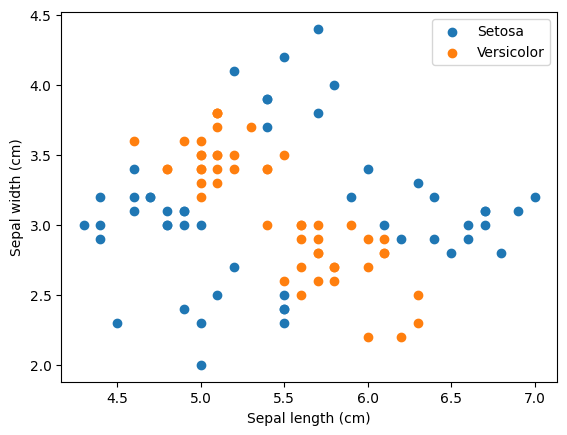

Epoch: 1


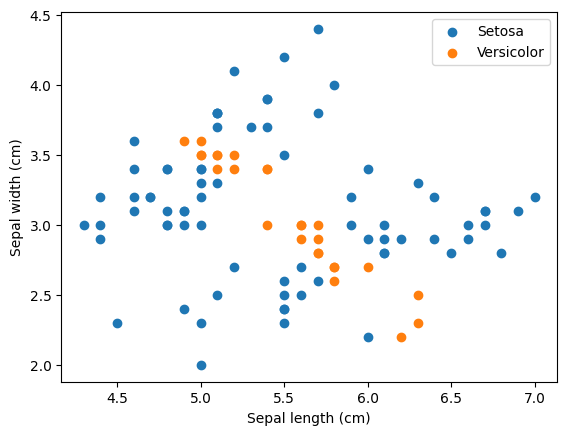

Epoch: 2


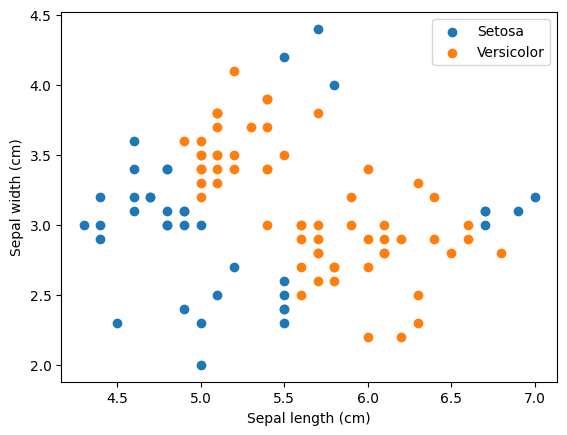

Epoch: 4


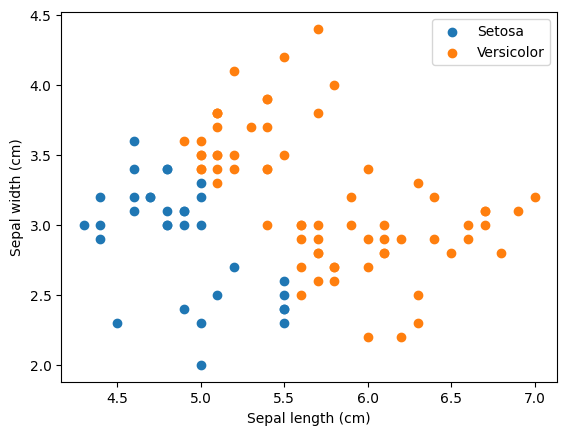

Epoch: 8


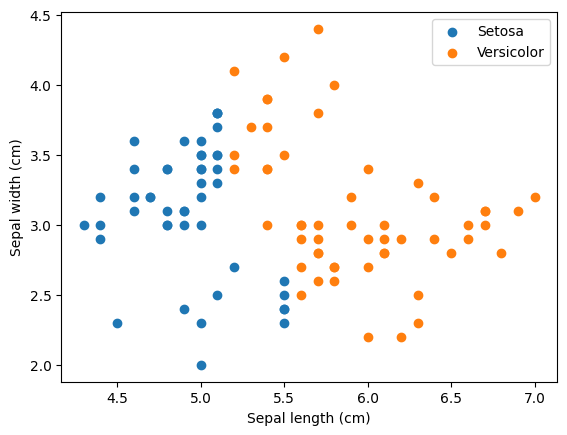

Epoch: 16


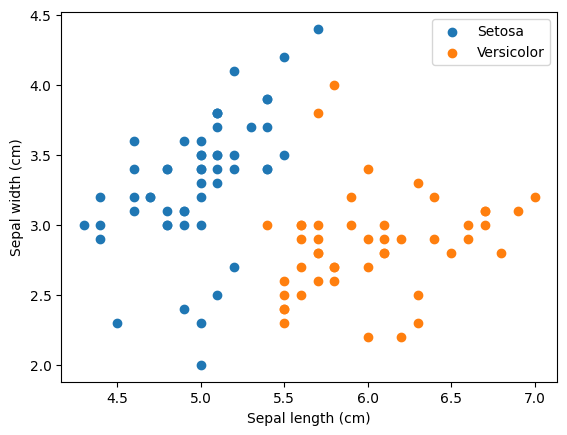

Epoch: 32


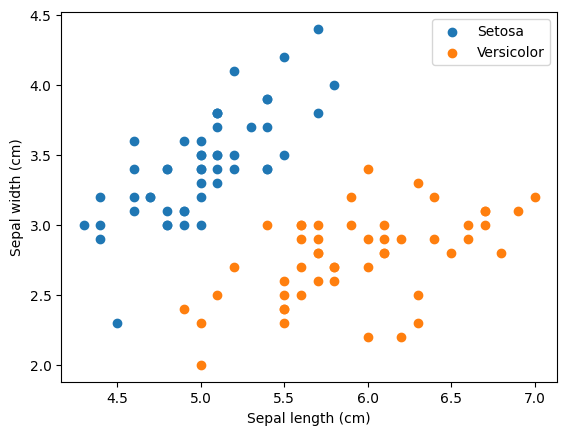

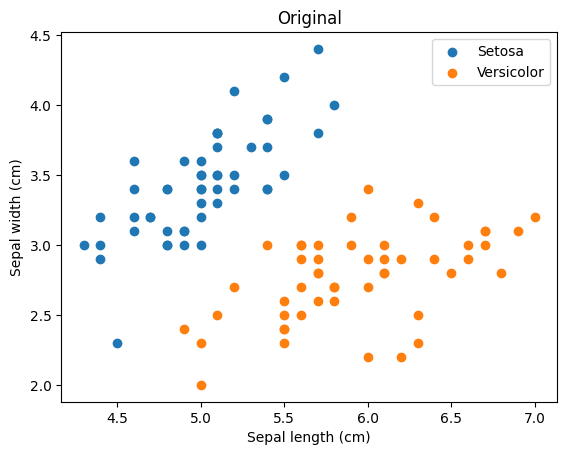

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import random

iris = datasets.load_iris()
iris_data = iris.data
sl_data = iris_data[:100, 0].copy() # SetosaとVersicolor、Sepal length: copy()で元データが変更されない
sw_data = iris_data[:100, 1].copy() # SetosaとVersicolor、Sepal width

# 平均値を0に
sl_ave = np.average(sl_data)  # 平均値
sl_data -= sl_ave  # 平均値を引く
sw_ave = np.average(sw_data)
sw_data -= sw_ave

# 入力をリストに格納
train_data = []
for i in range(100):  # iには0から99までが入る
    correct = iris.target[i]
    train_data.append([sl_data[i], sw_data[i], correct])

# シグモイド関数
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# ニューロン
class Neuron:
    def __init__(self):  # 初期設定
        self.input_sum = 0.0
        self.output = 0.0

    def set_input(self, inp):
        self.input_sum += inp

    def get_output(self):
        self.output = sigmoid(self.input_sum)
        return self.output

    def reset(self):
        self.input_sum = 0
        self.output = 0

# ニューラルネットワーク
class NeuralNetwork:
    def __init__(self):  # 初期設定
        # 重み
        self.w_im = [[4.0, 4.0], [4.0, 4.0]]  # 入力:2 ニューロン数:2
        self.w_mo = [[1.0, -1.0]]  # 入力:2 ニューロン数:1

        # バイアス
        self.b_m = [2.0, -2.0]  # ニューロン数:2
        self.b_o = [-0.5]  # ニューロン数:1

        # 各層の宣言
        self.input_layer = [0.0, 0.0]
        self.middle_layer = [Neuron(), Neuron()]
        self.output_layer = [Neuron()]

    def commit(self, input_data):  # 実行
        # 各層のリセット
        self.input_layer[0] = input_data[0]  # 入力層は値を受け取るのみ
        self.input_layer[1] = input_data[1]
        self.middle_layer[0].reset()
        self.middle_layer[1].reset()
        self.output_layer[0].reset()

        # 入力層→中間層
        self.middle_layer[0].set_input(self.input_layer[0] * self.w_im[0][0])
        self.middle_layer[0].set_input(self.input_layer[1] * self.w_im[0][1])
        self.middle_layer[0].set_input(self.b_m[0])

        self.middle_layer[1].set_input(self.input_layer[0] * self.w_im[1][0])
        self.middle_layer[1].set_input(self.input_layer[1] * self.w_im[1][1])
        self.middle_layer[1].set_input(self.b_m[1])

        # 中間層→出力層
        self.output_layer[0].set_input(self.middle_layer[0].get_output() * self.w_mo[0][0])
        self.output_layer[0].set_input(self.middle_layer[1].get_output() * self.w_mo[0][1])
        self.output_layer[0].set_input(self.b_o[0])

        return self.output_layer[0].get_output()

    def train(self, correct):
        # 学習係数
        k = 0.3

        #  出力
        output_o = self.output_layer[0].output
        output_m0 = self.middle_layer[0].output
        output_m1 = self.middle_layer[1].output

        # δ
        delta_o = (output_o - correct) * output_o * (1.0 - output_o)
        delta_m0 = delta_o * self.w_mo[0][0] * output_m0 * (1.0 - output_m0)
        delta_m1 = delta_o * self.w_mo[0][1] * output_m1 * (1.0 - output_m1)

        # パラメータの更新
        self.w_mo[0][0] -= k * delta_o * output_m0
        self.w_mo[0][1] -= k * delta_o * output_m1
        self.b_o[0] -= k * delta_o

        self.w_im[0][0] -= k * delta_m0 * self.input_layer[0]
        self.w_im[0][1] -= k * delta_m0 * self.input_layer[1]
        self.w_im[1][0] -= k * delta_m1 * self.input_layer[0]
        self.w_im[1][1] -= k * delta_m1 * self.input_layer[1]
        self.b_m[0] -= k * delta_m0 
        self.b_m[1] -= k * delta_m1 


# ニューラルネットワークのインスタンス
neural_network = NeuralNetwork()

# グラフ表示用の関数
def show_graph(epoch):
    print("Epoch:", epoch)
    # 実行
    st_predicted = [[], []]  # Setosa
    vc_predicted = [[], []]  # Versicolor
    for data in train_data:
        if neural_network.commit(data) < 0.5:
            st_predicted[0].append(data[0]+sl_ave)
            st_predicted[1].append(data[1]+sw_ave)
        else:
            vc_predicted[0].append(data[0]+sl_ave)
            vc_predicted[1].append(data[1]+sw_ave)

    # 分類結果をグラフ表示
    plt.scatter(st_predicted[0], st_predicted[1], label="Setosa")
    plt.scatter(vc_predicted[0], vc_predicted[1], label="Versicolor")
    plt.legend()

    plt.xlabel("Sepal length (cm)")
    plt.ylabel("Sepal width (cm)")
    plt.show()

show_graph(0)

# 学習と結果の表示
for t in range(0, 32):
    random.shuffle(train_data)
    for data in train_data:
        neural_network.commit(data[:2])  # 順伝播
        neural_network.train(data[2])  # 逆伝播
    if t+1 in [1, 2, 4, 8, 16, 32]:
        show_graph(t+1)

# 比較用に元の分類を散布図で表示
st_data = iris_data[:50]  # Setosa
vc_data = iris_data[50:100]  # Versicolor
plt.scatter(st_data[:, 0], st_data[:, 1], label="Setosa")
plt.scatter(vc_data[:, 0], vc_data[:, 1], label="Versicolor")
plt.legend()

plt.xlabel("Sepal length (cm)")
plt.ylabel("Sepal width (cm)")
plt.title("Original")
plt.show()

In [ ]:
# コード練習用
for t in range(0, 32):
    random.shuffle(train_data)
    for data in train_data:
        neural_network.commit(data[:2])
        neural_network.commit(data[2])
    if t + 1 in [1, 2, 4, 8, 16 , 32]:
        show_graph(t + 1)